# Example 3 &ndash; An excitator&ndash;inhibitor pair

In this example, we reproduce figures 12 to 14 of the paper [*Beyond Wilson-Cowan dynamics: oscillations and chaos without inhibition*](https://doi.org/10.1007/s00422-022-00941-w). For details on PopNet's functions, see the [documentation](https://vincentpainchaud.github.io/PopNet/) of the package.

In [1]:
import popnet as pn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.ioff()

We start by defining the configuration with all parameters used in this example.

In [2]:
excitators = pn.population('Excitators', size=1000)
excitators.set_means(alpha=10, beta=.8, gamma=4)
excitators.set_scales(theta=.4)

inhibitors = pn.population('Inhibitors', size=1000)
inhibitors.set_means(alpha=9, theta=3)
inhibitors.set_scales(theta=.4)

net = pn.network('2A', (excitators, inhibitors))
net.c = [[8, -12], [9, -2]]
net.reset_parameters()

config = pn.config(net)

config.initial_state = .4, .4, .08, .4
config.final_time = 20
config.delta = .01

## Solutions

First, we integrate numerically both the mean-field system and its subsystem that is equivalent to Wilson-Cowan's classical system. First, we perform the integration with PopNet's methods.

In [3]:
solutions = []
for system_name in ['wilson-cowan', 'mean-field']:
    integrator = pn.get_integrator(config, system_name)
    integrator.run('ode')
    solutions.append(integrator.output())
    integrator.close()

Then, we define a Matplotlib figure on which we will plot the results.

In [4]:
mm = 1/25.4
preamble = ('\\usepackage[cal=cm]{mathalpha}'
            '\\usepackage{helvet}'
            '\\usepackage{sansmath}'
            '\\sansmath'
            '\\usepackage{bm}')
fig, axes = pn.figure(subplots=(211, 212), figsize=(84*mm, 70*mm), font_family='sans-serif',
                      usetex=True, preamble=preamble, tight_layout=False)
fig.subplots_adjust(left=.07, right=.96, bottom=.125, top=.83)

The following function will be used to reorder the entries of the legend.

In [5]:
def reorder_entries(L):
    return [L[0], L[3], L[1], L[4], L[2], L[5]]

We plot the solution of the Wilson&ndash;Cowan's system on the top panel and that of the full mean-field system on the bottom panel.

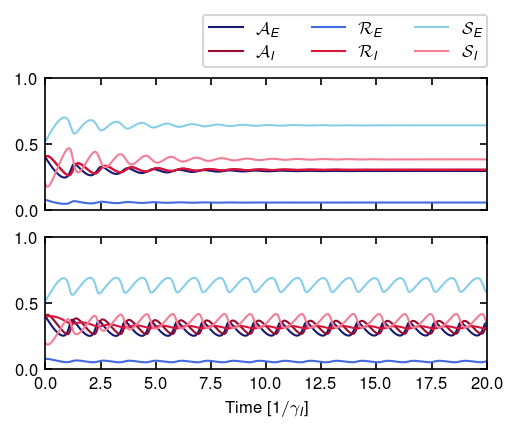

In [6]:
for j, solution in enumerate(solutions):
    solution.fig = fig
    solution.ax = axes[j]
    solution.plot_expectations(lw=1)
    solution.setup(units='$1/\\gamma_I$', set_xlabel=j==1, fontsize=8)
    solution.ax.tick_params(labelsize=8)
    if j == 0:
        solution.ax.set_xticklabels([])
        handles, labels = solution.ax.get_legend_handles_labels()
        handles = reorder_entries(handles)
        labels = reorder_entries(labels)
        solution.ax.legend(handles, labels, ncol=3, fontsize=8, loc='lower right', bbox_to_anchor=(1.02, 1.02))
pn.draw()

## Eigenvalues of the Jacobian matrix

Now, we compute the eigenvalues of the Jacobian matrix of the mixed system that describes the transition between the mean-field system and its Wilson&ndash;Cowan subsystem. First, we will need the position of the steady state to which the Wilson&ndash;Cowan subsystem converges, so we start by defining a new configuration with this steady state as initial state.

In [7]:
integrator = pn.get_integrator(config, 'mixed')
integrator.system.epsilon = .1
integrator.run('ode')
test_state = integrator.states[-1][:4]
steady_state = integrator.system.find_equilibrium_near(test_state)

steady_state_config = config.copy('2AS')
steady_state_config.initial_state = steady_state
steady_state_config.final_time = 1000
steady_state_config.delta = .01

We can now compute the eigenvalues of the Jacobian matrix for many values of &epsilon;.

In [8]:
epsilon = np.linspace(0, 1, 10001)
eigenvals = np.zeros((10001, 4), dtype=complex)

system = pn.get_system(steady_state_config, 'wilson-cowan')
eigenvals_WC = system.get_eigenvals_at(steady_state)
eigenvals[0,:2] = eigenvals_WC
eigenvals[0,2:] = None

system = pn.get_system(steady_state_config, 'mixed')
for j, e in enumerate(epsilon):
    if e == 0:
        continue
    system.epsilon = e
    eigenvals[j] = system.get_eigenvals_at(steady_state)

We also obtain an approximation (to 15 digits) of the value of the parameter &epsilon; at the bifurcation point.

In [9]:
epsilon_bifurcation, _ = system.find_bifurcation_near(steady_state, 15)
print(epsilon_bifurcation)

0.5589495194637306


Finally, we plot the real (on the top panel) and imaginary (on the bottom panel) parts of the eigenvalues. The figure is actually split in three, because the top plot is split in two: one for each side of the axis break.

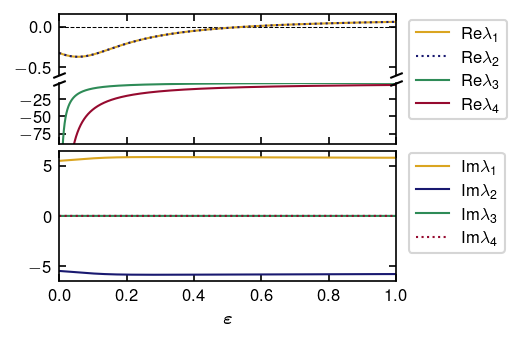

In [10]:
fig, axes = pn.figure(figsize=(84*mm, 54*mm), subplots=(411, 412, (4,1,(3,4))), font_family='sans-serif',
                      usetex=True, preamble=preamble, tight_layout=False)
fig.subplots_adjust(hspace=.12, left=.09, right=.77, bottom=.15, top=.985)

axes[0].plot([0,1], [0,0], '--', color='black', lw=.5)
lsRe = ['-', ':', '-', '-']
lsIm = ['-', '-', '-', ':']
colors = ['C2', 'C0', 'C3', 'C1']
for j, eig in enumerate(eigenvals.T):
    axes[0].plot(epsilon, np.real(eig), lsRe[j], color=colors[j], label=f'$\\mathrm{{Re}}\\lambda_{j+1}$', linewidth=1)
    if j >= 2:
        axes[1].plot(epsilon, np.real(eig), color=colors[j], label=f'$\\mathrm{{Re}}\\lambda_{j+1}$', linewidth=1)
    else:
        next(axes[1]._get_lines.prop_cycler)
    axes[2].plot(epsilon, np.imag(eig), lsIm[j], color=colors[j], label=f'$\\mathrm{{Im}}\\lambda_{j+1}$', linewidth=1)
for j, ax in enumerate(axes):
    ax.tick_params(labelsize=8)
    if j != 1:
        ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(1.0125, .05, 1, 1), fontsize=8)
    ax.set_xlim([0,1])
    if j != 2:
        ax.set_xticklabels([])

axes[0].spines.bottom.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[0].tick_params(bottom=False)
axes[1].tick_params(top=False)
axes[0].set_ylim([-.6, .15])
axes[1].set_ylim([-90,-.8])

kwargs = dict(marker=[(-1, -.4), (1, .4)], markersize=6, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)

axes[2].set_xlabel('$\\bm{\\varepsilon}$', fontsize=8)
pn.draw()

## Bifurcation diagram

Here, we draw bifurcation diagrams to visualize the Hopf bifurcation. Since the dynamical system has four dimensions, we would need five dimensions to draw a complete bifurcation diagram. Instead, we draw the four two-dimensional projections of the full diagram onto the &epsilon;&ndash;*X* subspaces, where *X* is one of the four macroscopic state variables. 

Since the system is less stable near the bifurcation point, we will need to other configurations to compute numerical integrations on longer time intervals.

In [11]:
longer_config = steady_state_config.copy('2AL')
longer_config.final_time = 10000
longer_config.delta = .01

longest_config = steady_state_config.copy('2ALL')
longest_config.final_time = 100000
longest_config.delta = .01

configs = [steady_state_config, longer_config, longest_config]

perturbation = 5e-7 * np.ones(4)
for conf in configs:
    conf.add_to_initial_state(perturbation)

integrators = {conf: pn.get_integrator(conf, 'mixed') for conf in configs}

Now, we integrate the mixed system for many different values of &epsilon;.

In [12]:
epsilon = np.linspace(0, 1, 1001)[1:]
maxima = np.zeros((len(epsilon), 4))
minima = np.zeros((len(epsilon), 4))

for j, e in tqdm(enumerate(epsilon)):
    if e <= .55:
        conf = steady_state_config
    elif e <= epsilon_bifurcation:
        conf = longest_config
    else:
        conf = longer_config
    integrator = integrators[conf]
    integrator.system.epsilon = e
    integrator.run('ode')
    index = int((conf.final_time - 10) / conf.delta)
    maxima[j] = np.amax(integrator.states[index:,:4], axis=0)
    minima[j] = np.amin(integrator.states[index:,:4], axis=0)
    integrator.reset()

1000it [5:24:37, 19.48s/it]


Finally, we draw the figure. We split it in four parts, one for each of the four state components.

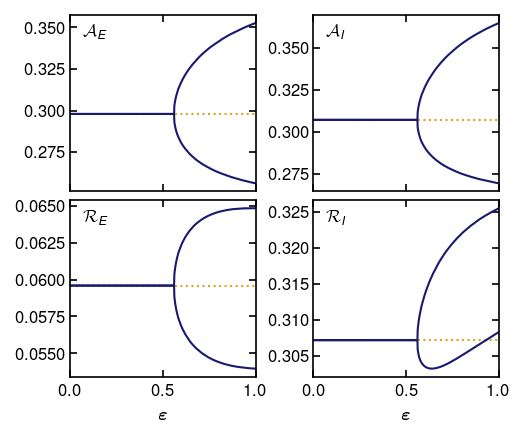

In [13]:
fig, axes = pn.figure(subplots=(221, 222, 223, 224), figsize=(84*mm, 70*mm), font_family='sans-serif',
                      usetex=True, preamble=preamble, tight_layout=False)
fig.subplots_adjust(left=.11, right=.975, bottom=.115, top=.99, hspace=.05, wspace=.31)
labels = {0: '$\\mathcal{A}_E$',
          1: '$\\mathcal{A}_I$',
          2: '$\\mathcal{R}_E$',
          3: '$\\mathcal{R}_I$'}

for j, ax in enumerate(axes):
    ax.plot([epsilon[0], epsilon[-1]], [steady_state[j], steady_state[j]], ':', color='C2', linewidth=1)
    ax.plot(epsilon, maxima[:,j], color='C0', linewidth=1)
    ax.plot(epsilon, minima[:,j], color='C0', linewidth=1)
    ax.text(.07, .88, labels[j], fontsize=8, transform=ax.transAxes)
    ax.set_xlim([0,1])
    if j > 1:
        ax.set_xlabel('$\\bm{\\varepsilon}$', fontsize=8)
    else:
        ax.set_xticklabels([])
    ax.tick_params(labelsize=8)
    ax.tick_params(axis='y', pad=2)
pn.draw()

## Trajectory

Finally, we compare the solutions illustrated above with the macroscopic behavior of a trajectory of the underlying Markov chain that describes the evolution of the network's state from a microscopic point of view. Note that since the trajectory is randomly generated, it is of course slightly different from the trajectory shown in the paper.

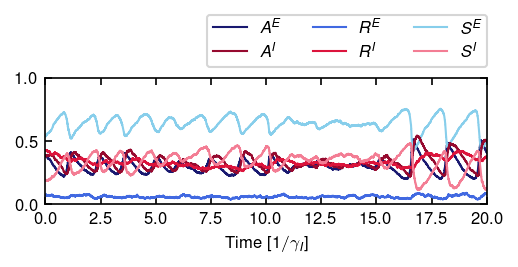

In [14]:
simulator = pn.get_simulator(config, act='sigmoid')
simulator.run()
trajectory = simulator.output()
simulator.close()

trajectory.activate(figsize=(84*mm, 42*mm), font_family='sans-serif', usetex=True, preamble=preamble, tight_layout=False)
trajectory.fig.subplots_adjust(left=.07, right=.96, bottom=.21, top=.72)

trajectory.plot_fractions(lw=1)
trajectory.setup(units='$1/\\gamma_I$', fontsize=8)
trajectory.ax.tick_params(labelsize=8)
trajectory.ax.set_xticks([2.5*n for n in range(9)])

handles, labels = trajectory.ax.get_legend_handles_labels()
handles = reorder_entries(handles)
labels = reorder_entries(labels)
trajectory.ax.legend(handles, labels, ncol=3, fontsize=8, loc='lower right', bbox_to_anchor=(1.02, 1.02))

pn.draw()